In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from matplotlib import gridspec
%matplotlib inline

In [2]:
filename = 'N-CMAPSS_DS02-006.h5'

In [3]:
# time tracking
t = time.process_time()  

# loading data
with h5py.File(filename, 'r') as hdf:
        
        # development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.015824750000000002

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [4]:
# creating the dataframes
df_A = DataFrame(data=A, columns=A_var)             # auxiliary information
df_W = DataFrame(data=W, columns=W_var)             # operative conditions 
df_X_s = DataFrame(data=X_s, columns=X_s_var)       # sensor readings
df_X_v = DataFrame(data=X_v, columns=X_v_var)       # virtual sensors
df_T = DataFrame(data=T, columns=T_var)             # degradation
df_Y = DataFrame(data=Y)                            # RUL

# concatinated DataFrame 
df = pd.concat([df_W, df_X_s, df_X_v, df_T, df_Y, df_A], axis=1)

In [5]:
# renaming RUL column
df = df.rename(columns = {0 : "RUL"})

In [6]:
def filter_zeros(df, treshold = 0.5):
    """Filtering out features that contain too much zero values"""
    
    to_drop = []
    zeros = df.apply(lambda x: sum(x == 0)).to_frame(name="count")
    half = df.shape[0] * treshold

    for i, row in zeros.iterrows():
        if row["count"] > half:
            to_drop.append(i)
    
    df = df.drop(columns = to_drop)

    return df

df = filter_zeros(df)

Text(0.5, 1.0, 'Sensor Readings Correlating with RUL')

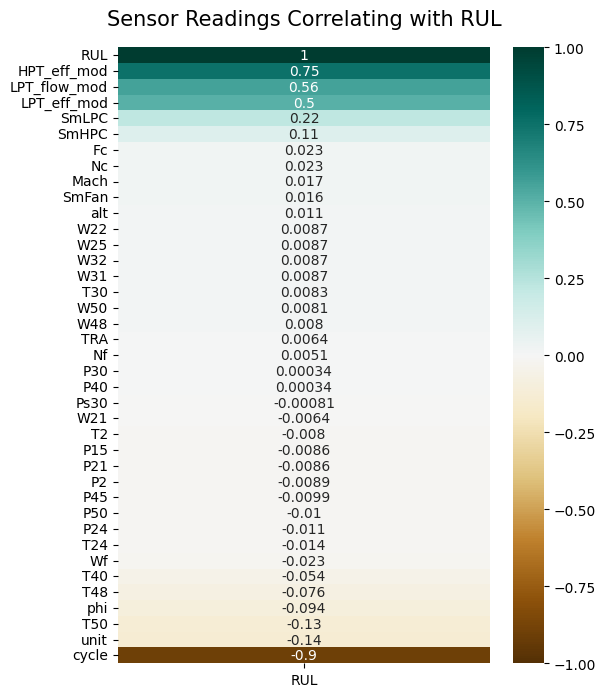

In [7]:
# correlation heatmap of RUL against all features
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Sensor Readings Correlating with RUL', fontdict={'fontsize':15}, pad=16)

In [8]:
def low_correlation(df, treshold = 0.2):
    """Filtering out features that have an exteremely low correlation with the target value RUL"""

    # calculate correlations
    correlations = df.corr()[['RUL']]

    # list of columns to drop 
    to_drop = []

    # filter out correlations not above treshold
    for i, row in correlations.iterrows():
        feature = i
        RUL_c = row["RUL"]

        if abs(RUL_c) < treshold or RUL_c == np.nan:
            to_drop.append(feature)

    df = df.drop(columns=to_drop)
    return df 
  
df = low_correlation(df)

In [9]:
df

,SmLPC,HPT_eff_mod,LPT_eff_mod,LPT_flow_mod,RUL,cycle
0,9.898130,-0.000638,0.000000,0.00000,74,1.0
1,9.904927,-0.000638,0.000000,0.00000,74,1.0
2,9.923503,-0.000638,0.000000,0.00000,74,1.0
3,9.905518,-0.000638,0.000000,0.00000,74,1.0
4,9.897465,-0.000638,0.000000,0.00000,74,1.0
...,...,...,...,...,...,...
6517185,6.788187,-0.010829,-0.011415,-0.01091,0,67.0
6517186,6.803624,-0.010829,-0.011415,-0.01091,0,67.0
6517187,6.810375,-0.010829,-0.011415,-0.01091,0,67.0
6517188,6.810105,-0.010829,-0.011415,-0.01091,0,67.0


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop(['RUL'], axis=1)  # features
y = df['RUL']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [12]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### Linear Regression

In [13]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:7.582774619399087, R2:0.8799724712809601
test set RMSE:7.583329184861977, R2:0.8800349382209122
